# Modelagem de Risco de Crédito com Precisão: Utilizando Random Forest para Prever o Futuro Financeiro



Este portfólio é uma exploração do poder do aprendizado de máquina aplicado a problemas do mundo real, traduzindo dados em informações significativas e auxiliando na tomada de decisões embasadas. Ele exemplifica como algoritmos como o Random Forest Classifier podem ser aliados indispensáveis em um setor tão vital quanto o financeiro, onde a precisão e a previsão são cruciais.

Ao capacitar as instituições financeiras com uma ferramenta que avalia de forma objetiva e precisa os riscos associados a cada candidato a empréstimo, o modelo Random Forest Classifier desempenha um papel significativo na mitigação de riscos financeiros. Ele contribui para a redução de perdas causadas por inadimplência e, ao mesmo tempo, permite a concessão de empréstimos a mutuários confiáveis que podem ser subestimados por abordagens tradicionais.

## Sobre o Dataset



Os dados utilizados neste projéto, estão disponiveis no site do kaggle no link indicado abaixo:

https://www.kaggle.com/datasets/laotse/credit-risk-dataset


Abaixo está a relação de recursos(variáveis) e uma breve descrição sobre os dados:
<br><br>
Nome do recurso e Descrição<br>
person_age:          Idade<br>
person_income:	Renda Anual<br>
person_home_ownership: 	Propriedade da casa<br>
person_emp_length:	Duração do emprego ( em anos )<br>
loan_intent:	Intenção de empréstimo<br>
loan_grade:	Grau de empréstimo<br>
loan_amnt:	Montante do empréstimo<br>
loan_int_rate:	Taxa de juro<br>
loan_status:	O status do empréstimo ( 0 não é padrão 1 é padrão )<br>
loan_percent_income:	Renda percentual<br>
cb_person_default_on_file:	Padrão histórico<br>
cb_preson_cred_hist_length:	Duração do histórico de crédito<br>

## Parte 1 - Carrega Bibliotecas e conjunto de Dados

In [1]:
# ========= bibliotecas =============

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import r2_score # para medir a acuracia do modelo
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler # para padronizar os dados
from sklearn.impute import SimpleImputer

import time
import gzip
import pickle
import joblib # para salvar o modelo preditivo

sns.set()
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# carrega o arquivo
arquivo = './datasets/credit_risk_dataset.csv'
df = pd.read_csv(arquivo)

## Parte 2 - Análise Exploratória dos dados

Nesta etapa, será feita uma análise exploratória dos dados, visando compreender sua distribuição e seu comportamento.

Etapas que serão aplicas:

* Tratamento de possíveis valores faltantes (missing).
* Transformações em algumas variáveis (colunas).
* Tratamendo de possíveis valores discrepantes (Outliers).
* Criação de novas colunas visando facilitar o entendimento dos dados.

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
# quantidade de linhas e colunas do dataset
df.shape

(32581, 12)

In [5]:
# verifica se ha valores nulos
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [6]:
# informações gerais do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


Como visto nas celulas acima, existem duas variáveis que no dataframe aparecem como numéricas, porém utilizando o comando ``info()`` do pandas, é possivel ver que no dtype aparecem como object.

Sendo assim,será necessário fazer a transformação do tipo (dtype) das variáveis ``person_emp_length`` e ``loan_int_rate`` de object para numeric usando o comando ``pandas.to_numeric(variavel_a_ser_transformada, errors='coerce')``

In [7]:
df.person_emp_length = pd.to_numeric(df.person_emp_length, errors='coerce')
df.loan_int_rate = pd.to_numeric(df.loan_int_rate, errors='coerce')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [9]:
# verifica se ha valores nulos
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Como visto acima, após a transformação das variáveis person_emp_length e loan_int_rate para numéricas surgiram valores núlos.
* person_emp_length: Duração do emprego ( em anos )
* loan_int_rate: Taxa de juros

Com relação a variável ``person_emp_length: Duração do emprego ( em anos )``, os valores nulos podem representar as pessoas que ainda estão ativas no emprego. Neste caso esses valores(nulos) serão preenchidos com a média da coluna em questão.

Com relação a variável ``loan_int_rate: Taxa de juros``, pode representar um emprestimo com taxa de juro em 0%, mas com esse tipo de taxa, não ha rentabilidade para a instituição bancária. Neste caso esses valores(nulos) serão preenchidos com a mediana da coluna em questão.

In [10]:
df.person_emp_length = df.person_emp_length.fillna(df.person_emp_length.mean())
df.loan_int_rate = df.loan_int_rate.fillna(df.loan_int_rate.median())

In [11]:
# verifica se ha valores nulos
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [13]:
# descrição geral dos dados
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.009620,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.085333,6322.086646,3.081611,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [14]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

Abaixo faremos uma análise visual das variaveis numéricas para entender as distribuições e assim se necessário poder realizar possíveis tratamentos.

In [15]:
numericas = [x for x in df.columns if df[x].dtypes == 'int64' or df[x].dtypes == 'float64']
numericas

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_cred_hist_length']

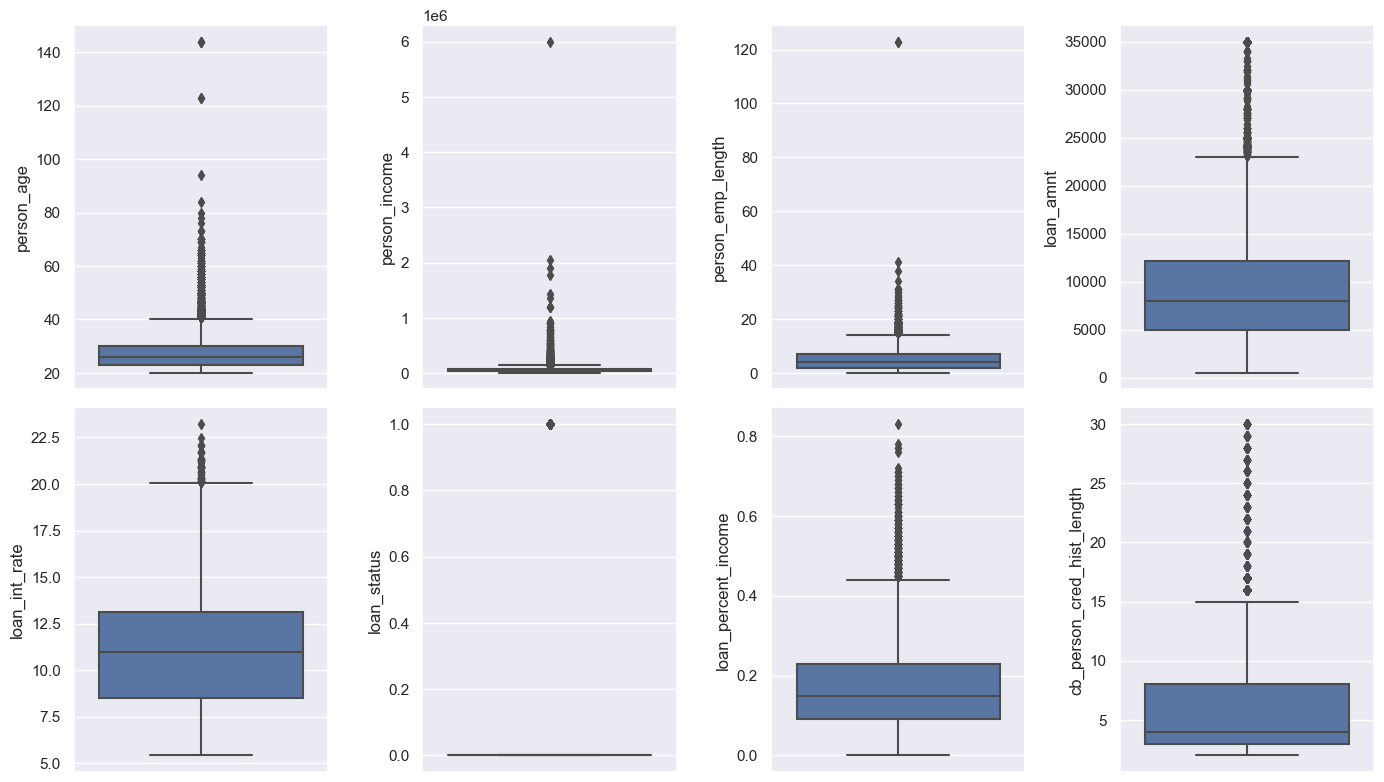

In [16]:
# criando um plot para ver a distribuição das variaveis numericas
plt.rcParams['figure.figsize'] = [14.00, 8.00]
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(2, 4)

linha = 0
coluna = 0

for i in numericas:
    sns.boxplot(data=df, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 4:
        linha += 1
        coluna = 0

plt.show()

Acima, podemos ver que na variável person_age (idade) os valores acima de 40 são vistos com possíveis outliers com registro de idade acima dos 140, o que demostra um possível erro na coleta dos dados. No entando, em uma rapida análise e considerando os dados onde a idade é acima de 90, temos 6 registros onde apenas um indice pode ser considerado aceitavel para compor o dataset, sendo este o indice 32416 onde a idade registrada é de 94 anos.

Com relação a variável person_income (Pessoa_renda), o maior registro é de 6000000, no entanto não será tratado como registro incorreto, pois possívelmente pode se tratar de renda de possíveis investimentos.

A variável person_emp_length (Duração de emprego (em anos)), apresenta valores acima de 120, o que sera descartado em análise posterior.

A variável loan_amnt (Montante do empréstimo), possui valor máximo de 35000, e será mantida em seu estado normal.

A variável loan_int_rate (Taxa de juro) ja passou por tratamentos anteriores e por isso também será mantida.

A variável loan_status (Status_do_empréstimo) a princípio será mantida, podendo receber tratamento de balanceamento de classe posteriormente.

A variável loan_percent_income (Renda percentual) a princípio será mantida.

A variável cb_preson_cred_hist_length (Duração do histórico de crédito) apresenta um valor máximo de 30, e por isso também será mantida como está.

---

A seguir, no conjunto de dados será considerado apenas valores onde a idade é até 94, e a duração de emprego é menor que 120 anos




In [17]:
df = df[(df['person_age'] <= 94) & (df['person_emp_length'] < 120)]

In [18]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


A baixo temos uma visualização das distribuições das variáveis numéricas após os tratamentos.

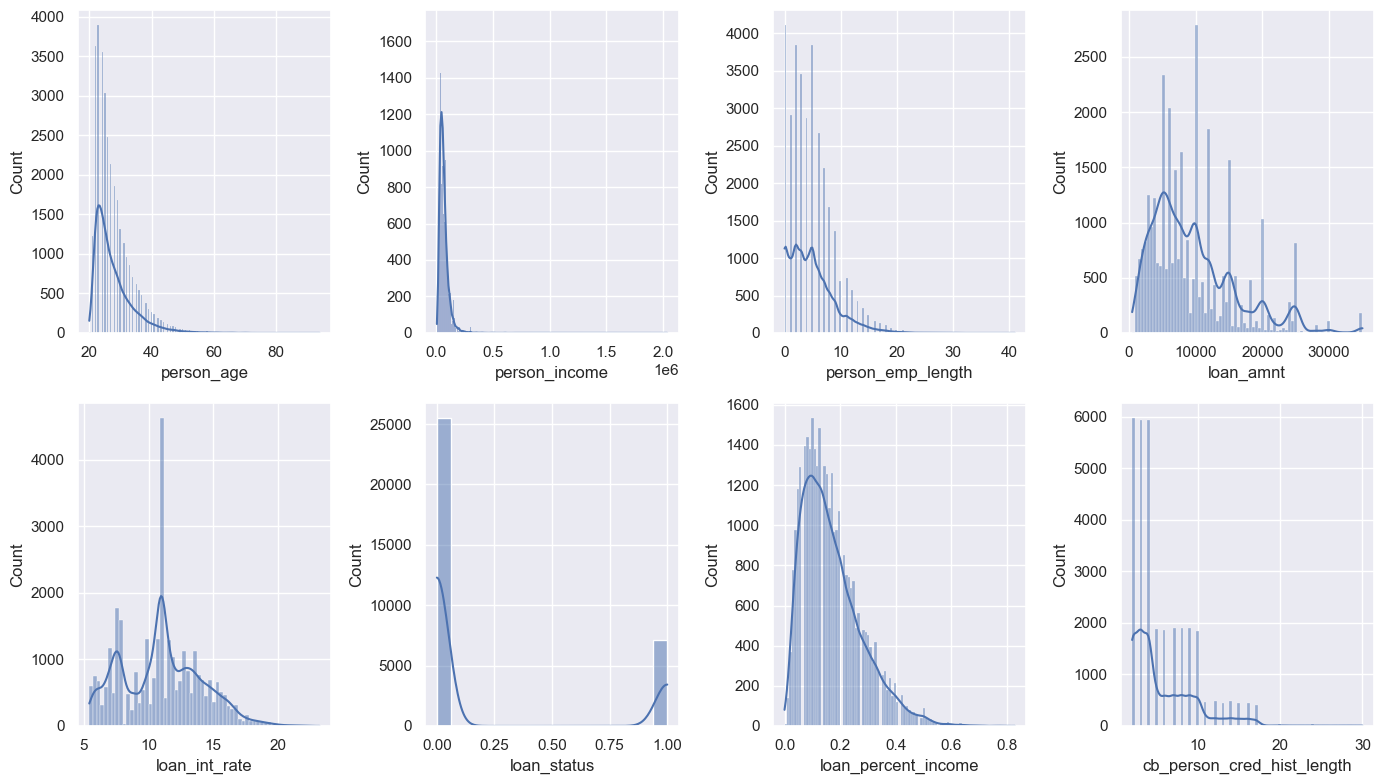

In [19]:
numericas = [x for x in df.columns if df[x].dtypes == 'int64' or df[x].dtypes == 'float64']
#numericas

# criando um plot para ver a distribuição das variaveis numericas
plt.rcParams['figure.figsize'] = [14.00, 8.00]
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(2, 4)

linha = 0
coluna = 0

for i in numericas:
    sns.histplot(data=df, x=i, ax=axes[coluna][linha], kde=True)
    linha += 1
    if linha == 4:
        coluna += 1
        linha = 0

plt.show()

**person_age:**
* Podemos ver que grande parte das pessoas registradas na base de dados, possui idade entre 20 e 40 anos, com uma concentração próxima a 4000 pessoas com idade aproximada entre 22 e 25 anos.

**person_income:**
* Com relação a renda anual, grande parte das pessoas cadastradas, possuem renda anual de menos de 5000, sendo 4000 a renda mínima registrada.

**person_emp_length:**
* Com relação ao tempo de empregabilidade das pessoas registradas na base de dados, a média de tempo é de 4 anos de emprego, havendo ainda um tempo mínimo registrado de 0, podendo representar pessoas sem registro de emprego ou trabalhadores liberais, e um tempo máximo de 41 anos de tempo de emprego.

**loan_amnt:**
* Sobre os valores solicitados como crédito, tem média registrada de 9588, sendo o valor mínimo de crédito solicitado de 500 e um valor máximo registrado de 35.000 solicitado de crédito.

**loan_int_rate:**
* Quanto a taxas de juros praticadas nas transações, ha registro de média de 11.09% de taxa de juros, sendo a mínima registrada de 5.42% e uma taxa máxima de 23.22%.

**loan_status:**
* Em relação ao status do empréstimo, 25467 pessoas cadastradas na base de dados, tiveram crédito negado e 7107 foram aprovadas para crédito.

**loan_percent_income:**
* Sobre o percentual de renda destinada ao financiamento do crédito, tem média registrada em torno de 0.17%, sendo o valor percentual máximo de 0.83% e menos de 1500 pessoas destinando este percentual ao financiamento do crédito solicitado.

**cb_preson_cred_hist_length:**
* Quanto a duração do histórico de crédito grande parte das pessoas registradas na base de dados, possui um tempo médio de 5 anos, sendo o tempo mínimo registrado de 2 anos e um tempo máximo de 30 anos.



## Parte 3 -  Pré-processamento de Dados

Nesta etapa serão aplicados os seguintes passos:

* Criação de novas variáveis
* Criação de função para processamento dos dados
* Divisão de dados em treino e teste
* Balanceamento de classes
* Criação do modelo classificador
* Validação cruzada para encontrar os melhores parametros que se ajustem ao modelo
* Treino e teste do modelo classificador
* Avaliação das Métricas e Variáveis mais Importantes

---

A seguir será criada novas colunas categóricas para facilitar a compreenção dos dados

In [20]:
# ### criando uma coluna com as faixas de idade
# # Definir os limites para cada faixa etária
age_bins = [18, 30, 40, 50, 60, 100]
age_labels = ['18-30', '31-40', '41-50', '51-60', '61+']

# adicionando nova coluna ao dataframe
df['person_age_group'] = pd.cut(df['person_age'], bins=age_bins, labels=age_labels, right=False)

# #### criando coluna com faixa de tempo de emprego
# person_emp_length_bins = [0, 5, 10, 20, 30, 50]
# person_emp_length_labels = ['0-5', '6-10', '11-20', '21-30', '30+']

# # adicionando nova coluna ao dataframe
# df['person_emp_length_group'] = pd.cut(df['person_emp_length'], bins=person_emp_length_bins, labels=person_emp_length_labels, right=False)

# ### criando coluna faixa de renda anual
# person_income_bins = [4000, 10000, 20000, 30000, 40000, 50000, 2039784]
# person_income_labels = ['4000-10000', '11000-20000', '21000-30000', '31000-40000', '41000-50000', '50000+']

# # adicionando nova coluna ao dataframe
# df['person_income_group'] = pd.cut(df['person_income'], bins=person_income_bins, labels=person_income_labels, right=False)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32574 entries, 1 to 32580
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32574 non-null  int64   
 1   person_income               32574 non-null  int64   
 2   person_home_ownership       32574 non-null  object  
 3   person_emp_length           32574 non-null  float64 
 4   loan_intent                 32574 non-null  object  
 5   loan_grade                  32574 non-null  object  
 6   loan_amnt                   32574 non-null  int64   
 7   loan_int_rate               32574 non-null  float64 
 8   loan_status                 32574 non-null  int64   
 9   loan_percent_income         32574 non-null  float64 
 10  cb_person_default_on_file   32574 non-null  object  
 11  cb_person_cred_hist_length  32574 non-null  int64   
 12  person_age_group            32574 non-null  category
dtypes: category(1), 

In [22]:
df1 = df.copy()

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32574 entries, 1 to 32580
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32574 non-null  int64   
 1   person_income               32574 non-null  int64   
 2   person_home_ownership       32574 non-null  object  
 3   person_emp_length           32574 non-null  float64 
 4   loan_intent                 32574 non-null  object  
 5   loan_grade                  32574 non-null  object  
 6   loan_amnt                   32574 non-null  int64   
 7   loan_int_rate               32574 non-null  float64 
 8   loan_status                 32574 non-null  int64   
 9   loan_percent_income         32574 non-null  float64 
 10  cb_person_default_on_file   32574 non-null  object  
 11  cb_person_cred_hist_length  32574 non-null  int64   
 12  person_age_group            32574 non-null  category
dtypes: category(1), 

In [24]:
categoricas = [x for x in df1.columns if df1[x].dtypes == 'object' or df1.dtypes[x] == 'category']
categoricas

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'person_age_group']

In [25]:
numericas = [x for x in df1.columns if df1[x].dtypes == 'int64' or df1[x].dtypes == 'float64']
numericas

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [26]:
def createXy(df, input_columns, output_column):
    
    minmax = MinMaxScaler()
    onehot = OneHotEncoder(sparse=False, drop='first')
    sm = SMOTE(random_state=42)

    df.dropna(axis=0, inplace=True)
    X = df[input_columns].copy()
    X_num = X.select_dtypes(exclude=['object', 'category'])
    X_num = minmax.fit_transform(X_num)
    X_num = pd.DataFrame(data=X_num, columns=X.select_dtypes(exclude=['object', 'category']).columns)

    X_cat = X.select_dtypes(include=['object', 'category'])
    X_cat = onehot.fit_transform(X_cat)
    columns = []
    for c, values in zip(X.select_dtypes(include=['object', 'category']).columns, onehot.categories_):       
        for value in values[1:]:
            columns.append(f'{c}_{value}')
    X_cat = pd.DataFrame(data=X_cat, columns=columns)
    X = X_num.join(X_cat)
    y = df[output_column].copy()

    return X, y

X, y = createXy(df1, ['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'person_age_group'], 'loan_status')


In [27]:
X.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,person_age_group_31-40,person_age_group_41-50,person_age_group_51-60,person_age_group_61+
0,0.013514,0.002751,0.121951,0.014493,0.321348,0.120482,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.067568,0.002751,0.024390,0.144928,0.418539,0.686747,0.035714,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.040541,0.030209,0.097561,1.000000,0.551124,0.638554,0.000000,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.054054,0.024757,0.195122,1.000000,0.497191,0.662651,0.071429,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.013514,0.002898,0.048780,0.057971,0.096629,0.301205,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
y

1        0
2        1
3        1
4        1
5        1
        ..
32576    0
32577    0
32578    1
32579    0
32580    0
Name: loan_status, Length: 32574, dtype: int64

A seguir, os dados serão divididos em treino e teste, sendo reservados 30% dos dados para o teste.

Um balanceamento de classes da variável alvo se fará necessário, que será feita apenas nos dados de treino, uma vez que no mundo real, os dados de fato são desbalanceados

In [29]:
# divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# seed para reproduzir o mesmo resultado
seed = 100

# cria um balanceador SMOTE
balanceador = SMOTE(random_state= seed)

# aplica o balanceador
X_train_bal, y_train_bal = balanceador.fit_resample(X_train, y_train)

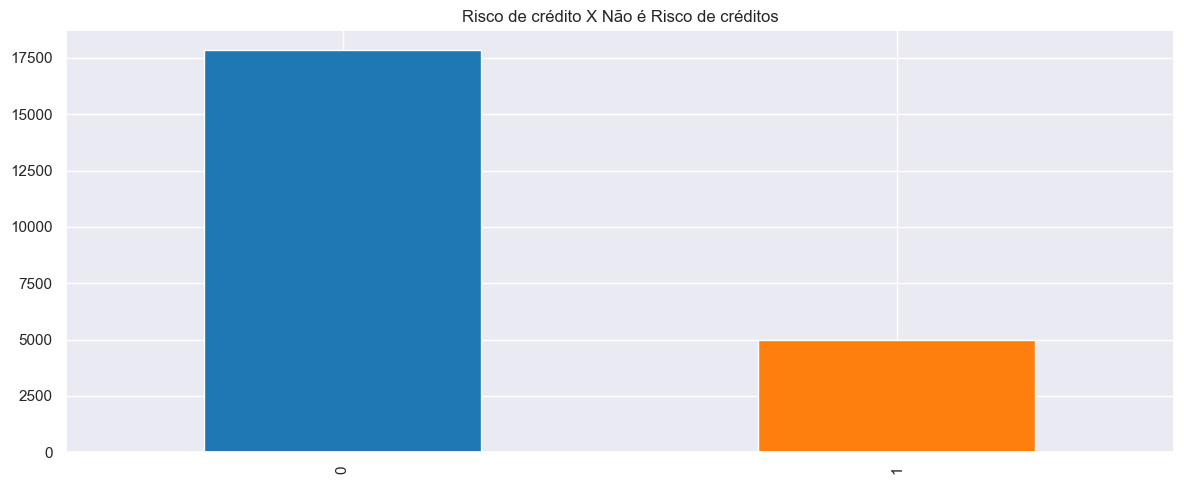

In [30]:
# variavel alvo antes do balanceamento

plt.rcParams['figure.figsize'] = [12.00, 5.00]
plt.rcParams['figure.autolayout'] = True
y_train.value_counts().plot(kind='bar',  title= 'Risco de crédito X Não é Risco de créditos', color=['#1F77B4', '#FF7F0E'])
plt.show()

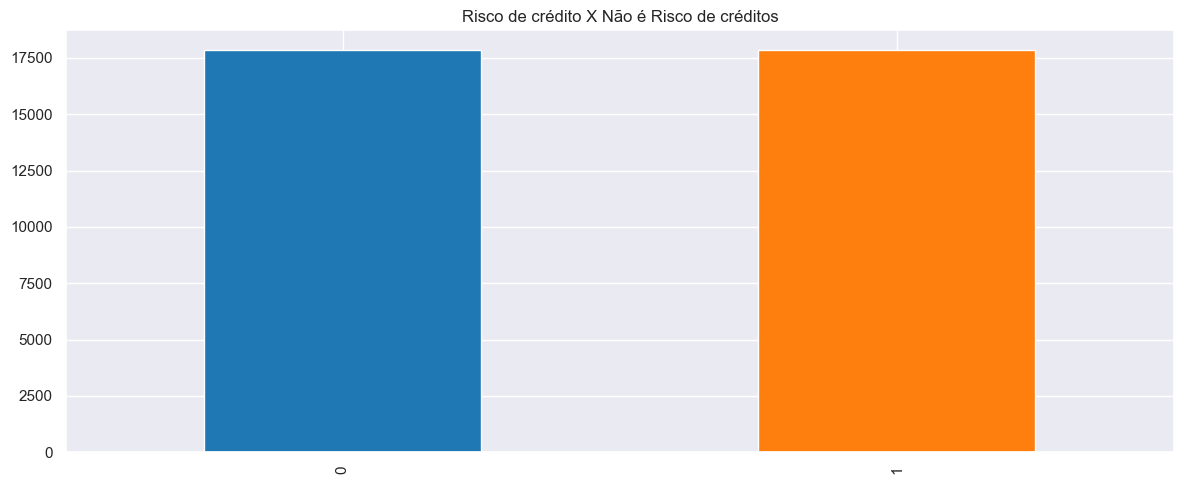

In [31]:
# variavel alvo após o balanceamento

plt.rcParams['figure.figsize'] = [12.00, 5.00]
plt.rcParams['figure.autolayout'] = True
y_train_bal.value_counts().plot(kind='bar',  title= 'Risco de crédito X Não é Risco de créditos', color=['#1F77B4', '#FF7F0E'])
plt.show()

In [32]:
# criando um classificador
clf = RandomForestClassifier(random_state=42)

# treina o classificador e verifica o score
clf.fit(X_train_bal, y_train_bal)
clf.score(X_test, y_test)

0.9234626010436918

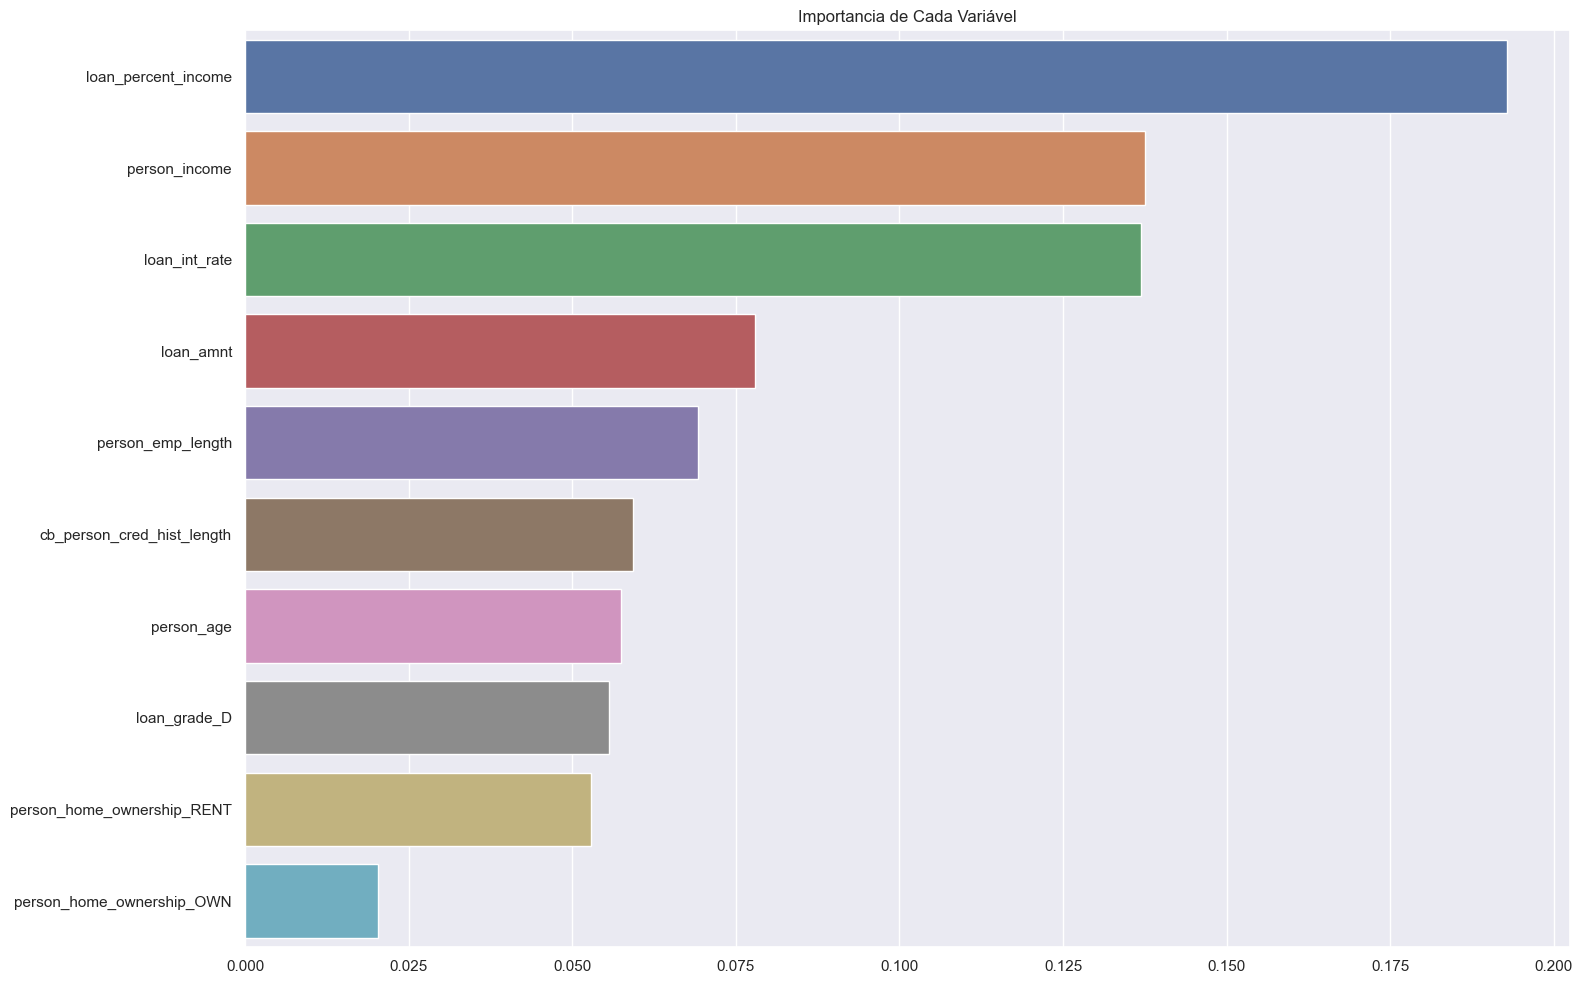

In [33]:
# exibindo as 10 variaveis consideradas mais importantes
plt.rcParams['figure.figsize'] = [16.00, 10.00]
plt.rcParams['figure.autolayout'] = True

importances = pd.Series(data=clf.feature_importances_, index=X_train_bal.columns)
importances = importances.sort_values(ascending=False).head(10)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importancia de Cada Variável')
plt.show()

In [34]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
# numero de arvores
n_estimators = [int(x) for x in np.linspace(start=300, stop= 500, num=20)]

# quantidade maxima de variaveis
max_features = ['auto', 'sqrt']

# profundidade maxima da arvore
max_depth = [int(x) for x in np.linspace(15, 35, num=7)]
max_depth.append(None)

#
criterion = ['gini', 'entropy']

# numero de amostras para cada quebra
min_samples_split = [2, 3, 5]

# numero de amostras na folha
min_samples_leaf = [1, 2, 4]

#
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'criterion': criterion,##
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

for x, y in random_grid.items():
    print(x, y)

n_estimators [300, 310, 321, 331, 342, 352, 363, 373, 384, 394, 405, 415, 426, 436, 447, 457, 468, 478, 489, 500]
max_features ['auto', 'sqrt']
max_depth [15, 18, 21, 25, 28, 31, 35, None]
criterion ['gini', 'entropy']
min_samples_split [2, 3, 5]
min_samples_leaf [1, 2, 4]


In [36]:
# validação cruzada para escolher os melhores hiperparametros
rf_random = RandomizedSearchCV(estimator= clf,
                               param_distributions= random_grid,
                               n_iter= 4,
                               cv= 5,
                               verbose=3,
                               random_state= 42)

# fit RandomizedSearchCV
rf_random.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END criterion=gini, max_depth=21, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300;, score=0.861 total time=  20.3s
[CV 2/5] END criterion=gini, max_depth=21, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300;, score=0.908 total time=  20.3s
[CV 3/5] END criterion=gini, max_depth=21, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300;, score=0.921 total time=  19.6s
[CV 4/5] END criterion=gini, max_depth=21, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300;, score=0.929 total time=  22.2s
[CV 5/5] END criterion=gini, max_depth=21, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300;, score=0.929 total time=  17.7s
[CV 1/5] END criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=405;, score=0.865 total time=  39.3s
[CV 2/5] END criter

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [15, 18, 21, 25, 28, 31,
                                                      35, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [300, 310, 321, 331,
                                                         342, 352, 363, 373,
                                                         384, 394, 405, 415,
                                                         426, 436, 447, 457,
                                                         468, 478, 489, 500]},
                   random_state=42, verbose=3)

In [37]:
# Obtendo e visualizando os parametros treinados
treinos = pd.DataFrame(rf_random.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {rf_random.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {rf_random.best_params_}")
print("")
# print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
# print("")
print("Numero de treinamentos realizados: ", treinos.shape[0])

Acurácia em Treinamento: 93.84%

Hiperparâmetros Ideais: {'n_estimators': 363, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 35, 'criterion': 'entropy'}

Numero de treinamentos realizados:  4


In [38]:
# melhores parametros encontrados para o modelo
rf_random.best_params_

{'n_estimators': 363,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 35,
 'criterion': 'entropy'}

In [39]:
# criando novo modelo com novos parametros
new_clf = RandomForestClassifier(n_estimators=363,
                                 min_samples_split= 2,
                                 min_samples_leaf= 1,
                                 max_features= 'sqrt',
                                 max_depth= 35,
                                 criterion = 'entropy')

# treina o modelo
new_clf.fit(X_train_bal, y_train_bal)

# verifica a acuracia do modelo
scores = new_clf.score(X_test, y_test)
scores

0.9252020873836079

In [40]:
# aplicando o modelo
y_pred = new_clf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [41]:
# exibindo as probabilidades do modelo
y_pred_proba = new_clf.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.14049587, 0.14876033, 0.03305785, ..., 0.24912023, 0.8953168 ,
       0.02754821])

In [42]:
# só pra testar mesmo
df_test = pd.DataFrame({'atual': y_test, 'predict': y_pred, 'probabilidade': y_pred_proba})
df_test

,atual,predict,probabilidade
14453,0,0,0.140496
24616,0,0,0.148760
11102,0,0,0.033058
10430,1,1,0.997245
12634,0,0,0.110193
...,...,...,...
18226,0,0,0.079932
32197,1,0,0.171534
19658,0,0,0.249120
22528,1,1,0.895317


In [43]:
# aplicando o modelo a variavel X
y_pred = new_clf.predict(X)
y_pred

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

In [44]:
# exibindo as probabilidades do modelo
y_pred_proba = new_clf.predict_proba(X)[:, 1]
y_pred_proba

array([0.1046832 , 0.98071625, 0.96969697, ..., 0.97520661, 0.0055841 ,
       0.03581267])

In [45]:
# adicionando novas colunas com predições e probabilidades ao df original(tratado)
df['predict'] = y_pred
df['probability'] = y_pred_proba

In [46]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_age_group,predict,probability
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,18-30,0,0.104683
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,18-30,1,0.980716
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,18-30,1,0.969697
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,18-30,1,0.942149
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2,18-30,1,0.906336


In [47]:
# salvando o modelo criado e treinado
#joblib.dump(new_clf, './modelo/modelo_new_clf_treinado.pk')

# Salvar o modelo comprimido
with gzip.open('./modelo/modelo_new_clf_treinado.pk.gz', 'wb') as f:
    joblib.dump(clf, f)

## Parte 4 - Organização do Script para Produção

In [48]:
# ========= bibliotecas =============
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import r2_score # para medir a acuracia do modelo
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler # para padronizar os dados
from sklearn.impute import SimpleImputer

import time
import gzip
import pickle
import joblib # para salvar o modelo preditivo

# Carregar o modelo comprimido
with gzip.open('./modelo/modelo_new_clf_treinado.pk.gz', 'rb') as f:
    clf = joblib.load(f)

#clf = joblib.load('./modelo/modelo_new_clf_treinado.pk')

sns.set()
%matplotlib inline
warnings.filterwarnings('ignore')

# carrega o arquivo
arquivo = './datasets/credit_risk_dataset.csv'



# tratamento e limpeza de arquivo
def load_df(arquivo):
    df = pd.read_csv(arquivo)
    print('Arquivos recebidos...\nTratando os arquivos...')

    # converte colunas para numerica
    df.person_emp_length = pd.to_numeric(df.person_emp_length, errors='coerce')
    df.loan_int_rate = pd.to_numeric(df.loan_int_rate, errors='coerce')

    # preenche nulos com a media e mediana
    df.person_emp_length = df.person_emp_length.fillna(df.person_emp_length.mean())
    df.loan_int_rate = df.loan_int_rate.fillna(df.loan_int_rate.median())

    # extrai amostra considerando menor idade de 94 e tempo de emprego menor que 120
    df = df[(df['person_age'] <= 94) & (df['person_emp_length'] < 120)]

    # # Definir os limites para cada faixa etária
    age_bins = [18, 30, 40, 50, 60, 100]
    age_labels = ['18-30', '31-40', '41-50', '51-60', '61+']

    # adicionando nova coluna ao dataframe
    df['person_age_group'] = pd.cut(df['person_age'], bins=age_bins, labels=age_labels, right=False)

    print('Arquivos carregados e tratados com sucesso...')

    return df

# pre-processamento e separação dos dados
def createXy(df, input_columns, output_column):

    print('Preparando os arquivos para o processamento...')
    minmax = MinMaxScaler()
    onehot = OneHotEncoder(sparse=False, drop='first')
    sm = SMOTE(random_state=42)

    df.dropna(axis=0, inplace=True)
    X = df[input_columns].copy()
    X_num = X.select_dtypes(exclude=['object', 'category'])
    X_num = minmax.fit_transform(X_num)
    X_num = pd.DataFrame(data=X_num, columns=X.select_dtypes(exclude=['object', 'category']).columns)

    X_cat = X.select_dtypes(include=['object', 'category'])
    X_cat = onehot.fit_transform(X_cat)
    columns = []
    for c, values in zip(X.select_dtypes(include=['object', 'category']).columns, onehot.categories_):
        for value in values[1:]:
            columns.append(f'{c}_{value}')
    X_cat = pd.DataFrame(data=X_cat, columns=columns)
    X = X_num.join(X_cat)
    y = df[output_column].copy()
    print('Arquivos processados com sucesso...')

    return X, y

# previsao e adiciona colunas ao novo dataset
def df_proba(X,df):
    previsoes = clf.predict(X)
    probabilidades = clf.predict_proba(X)
    df['predict'] = previsoes
    df['probability'] = probabilidades[:, 1]
    print('Novo DataFrame gerado com sucesso...\n')
    return df

def create_df():
    # carrega e transforma o arquivo
    df = load_df(arquivo)
    # processa os dados
    X, y = createXy(df, ['person_age', 'person_income', 'person_home_ownership',
        'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
        'loan_int_rate', 'loan_percent_income',
        'cb_person_default_on_file', 'cb_person_cred_hist_length',
        'person_age_group'], 'loan_status')
    df_new_pred = df_proba(X, df)
    df_new_pred.to_csv('./datasets/df_new_pred.csv', index=False)
    print('Arquivo .csv gerado com sucesso')

    return None

In [49]:
create_df()

Arquivos recebidos...
Tratando os arquivos...
Arquivos carregados e tratados com sucesso...
Preparando os arquivos para o processamento...
Arquivos processados com sucesso...
Novo DataFrame gerado com sucesso...

Arquivo .csv gerado com sucesso


In [50]:
df_new_pred = pd.read_csv('./datasets/df_new_pred.csv')
df_new_pred.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_age_group,predict,probability
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,18-30,0,0.04
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,18-30,1,0.98
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,18-30,1,0.99
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,18-30,1,0.97
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2,18-30,1,0.93
